In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import pandas as pd
from PIL import Image
import numpy as np


In [2]:
df = pd.read_csv('StenosisDetection/train_labels.csv', usecols=['filename','xmax','ymax','xmin', 'ymin'])

In [3]:
image_size = 224  
images, targets = [], []

top_left_x_collection = []
top_left_y_collection = []
bottom_right_x_collection = []
bottom_right_y_collection = [] 


In [4]:
for index, row in df.iterrows():
    image = keras.utils.load_img(
        'StenosisDetection/dataset/'+row['filename'],
    )

    (w, h) = image.size[:2]
    image = image.resize((224, 224))
    images.append(keras.utils.img_to_array(image))
    
    
    top_left_x, top_left_y = row['xmax'], row['ymax']
    bottom_right_x, bottom_right_y = row['xmin'], row['ymin']
    
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )


In [5]:
df_test = pd.read_csv('StenosisDetection/test_labels.csv', usecols=['filename','xmax','ymax','xmin', 'ymin'])


In [6]:
image_size = 224  
images_test, targets_test = [], [] 


In [7]:
for index, row in df_test.iterrows():
    image = keras.utils.load_img(
        'StenosisDetection/dataset/'+row['filename'],
    )

    (w, h) = image.size[:2]
    image = image.resize((224, 224))
    images_test.append(keras.utils.img_to_array(image))
    
    
    top_left_x, top_left_y = row['xmax'], row['ymax']
    bottom_right_x, bottom_right_y = row['xmin'], row['ymin']
    
    targets_test.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )


In [8]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images))]),
    np.asarray(targets[: int(len(targets))]),
)
(x_test), (y_test) = (
    np.asarray(images_test[: int(len(images_test))]),
    np.asarray(targets_test[: int(len(targets_test))]),
)


In [9]:
y_train.shape

(7493, 4)

In [10]:
y_train[0]

array([0.3525 , 0.24   , 0.29375, 0.195  ])

In [11]:
y_train.shape

(7493, 4)

In [12]:
# x = keras.layers.InputShape()
# x = keras.layers.Patches()(x)
# x = PatchEncoder(patches)


In [13]:
from tensorflow.keras.applications import inception_v3


In [14]:
def basemodel(weights='imagenet', input_shape=(224, 224, 1), unfreeze=True, unfreeze_from=15, include_top=False):
    base_model = inception_v3.InceptionV3(
    include_top=include_top,
    weights=weights,
    input_shape=input_shape
    )
    return base_model


In [15]:
def intermediatemodel(base_model, output_index_layer, unfreeze=False, unfreeze_from=0):
    intermediate_layer_model = keras.Model(inputs=base_model.input,
                                     outputs=base_model.get_layer(index=output_index_layer).output)

    i = 0
    for layer in intermediate_layer_model.layers:
        print(layer.name)
        print(i)
        i += 1
        layer.trainable = False

    if unfreeze:
        for layer in intermediate_layer_model.layers[unfreeze_from:]:
            layer.trainable = True

    for layer in intermediate_layer_model.layers:
        print("{}: {}".format(layer, layer.trainable))

    return intermediate_layer_model



In [16]:

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
# def predictionmodel(base_model, dense_sizes=[128], dense_activations=['relu'],
#                     dense_kernel_inits=['random_uniform'], dropout_p=[0.5],
#                     pooling='avg', classes=1,
#                     class_activation='sigmoid'):
#     input_shape = base_model.output.shape
#     model = Sequential()
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(input_shape[1],input_shape[2],input_shape[3])))
#     model.add(Dropout(0.5))
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(16, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
#     model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='random_uniform'))


#         predictions = Dense(classes, activation=class_activation, name='Output')(x)

#     return model


In [17]:
def predictionmodel(base_model, dense_sizes=[128], dense_activations=['relu'],
                    dense_kernel_inits=['random_uniform'], dropout_p=[0.5],
                    pooling='avg', classes=1,
                    class_activation='sigmoid'):
    x = base_model.output
    x= layers.Flatten()(x)

#     x= layers.Dropout(0.3)(x)
    # Add MLP.
    x= layers.Dense(256)(x)
    x= layers.Dropout(0.1)(x)
    x= layers.Dense(128)(x)
    x= layers.Dropout(0.1)(x)

#     predictions = layers.Dense(4)(x)
    
    
    
    
#     x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2,2))(x)
#     x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2,2))(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     predictions = layers.Dense(4, activation='sigmoid')(x)


#     x = keras.layers.Flatten()(x)

#     for i, (ds, da, dki, dop) in enumerate(zip(dense_sizes, dense_activations, dense_kernel_inits, dropout_p)):
#         x = Dense(ds, activation=da, kernel_initializer=dki)(x)
#         name = 'Dropout_Regularization_' + str(i)
#         x = Dropout(dop, name=name)(x)
#     predictions = Dense(classes, activation=class_activation, name='Output')(x)

    predictions = layers.Dense(4, activation='sigmoid')(x)

    
    
    return predictions


In [18]:
base_model = basemodel(input_shape=(224, 224, 3))
len(base_model.layers)

2023-03-08 01:46:41.502265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 01:46:41.503883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


311

In [19]:
base_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

In [20]:
# midmodel = intermediatemodel(base_model, 86)

midmodel = intermediatemodel(base_model, len(base_model.layers) - 1)



input_1
0
conv2d
1
batch_normalization
2
activation
3
conv2d_1
4
batch_normalization_1
5
activation_1
6
conv2d_2
7
batch_normalization_2
8
activation_2
9
max_pooling2d
10
conv2d_3
11
batch_normalization_3
12
activation_3
13
conv2d_4
14
batch_normalization_4
15
activation_4
16
max_pooling2d_1
17
conv2d_8
18
batch_normalization_8
19
activation_8
20
conv2d_6
21
conv2d_9
22
batch_normalization_6
23
batch_normalization_9
24
activation_6
25
activation_9
26
average_pooling2d
27
conv2d_5
28
conv2d_7
29
conv2d_10
30
conv2d_11
31
batch_normalization_5
32
batch_normalization_7
33
batch_normalization_10
34
batch_normalization_11
35
activation_5
36
activation_7
37
activation_10
38
activation_11
39
mixed0
40
conv2d_15
41
batch_normalization_15
42
activation_15
43
conv2d_13
44
conv2d_16
45
batch_normalization_13
46
batch_normalization_16
47
activation_13
48
activation_16
49
average_pooling2d_1
50
conv2d_12
51
conv2d_14
52
conv2d_17
53
conv2d_18
54
batch_normalization_12
55
batch_normalization_14
56
b

In [21]:
headmodel = predictionmodel(midmodel, pooling=None)


In [33]:
model = keras.Model(inputs=midmodel.input, outputs=headmodel)


In [34]:
model.output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_2')>

In [35]:
y_train.shape

(7493, 4)

In [36]:
base_model_input_shape = model.input_shape
model.build(input_shape=base_model_input_shape)

In [37]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
                mode='min',
                monitor='val_loss',
                factor=0.1,
                min_lr=5e-7,
                patience=10,
                verbose=1)
    

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
                monitor="val_loss",
                patience=10,
                mode="min",
                restore_best_weights=True,
                verbose=1)

In [39]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.001,
                      momentum=0.9,
                      name="SGD")

In [40]:
model.compile(loss='binary_crossentropy',metrics=['acc'])

In [41]:
#mse

In [42]:
model.fit(x=x_train, y=y_train, epochs=150, batch_size=35)

Epoch 1/150


2023-03-08 01:51:28.433711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 123s 494ms/step - loss: 1.4810 - acc: 0.4646
Epoch 2/150
215/215 [==============================] - 102s 473ms/step - loss: 1.0036 - acc: 0.5337
Epoch 3/150
215/215 [==============================] - 101s 470ms/step - loss: 0.9119 - acc: 0.6019
Epoch 4/150
215/215 [==============================] - 101s 469ms/step - loss: 0.7888 - acc: 0.6156
Epoch 5/150
215/215 [==============================] - 102s 474ms/step - loss: 0.7064 - acc: 0.6191
Epoch 6/150
215/215 [==============================] - 102s 473ms/step - loss: 0.6736 - acc: 0.6335
Epoch 7/150
215/215 [==============================] - 102s 473ms/step - loss: 0.6616 - acc: 0.6418
Epoch 8/150
215/215 [==============================] - 102s 472ms/step - loss: 0.6531 - acc: 0.6730
Epoch 9/150
215/215 [==============================] - 101s 472ms/step - loss: 0.6544 - acc: 0.6896
Epoch 10/150
215/215 [==============================] - 102s 473ms/step - loss: 0.6540 - acc: 0.6840
Epoch 11/15

215/215 [==============================] - 102s 474ms/step - loss: 0.6500 - acc: 0.6996
Epoch 83/150
215/215 [==============================] - 102s 475ms/step - loss: 0.6500 - acc: 0.7005
Epoch 84/150
215/215 [==============================] - 102s 472ms/step - loss: 0.6500 - acc: 0.6996
Epoch 85/150
215/215 [==============================] - 102s 472ms/step - loss: 0.6500 - acc: 0.6992
Epoch 86/150
215/215 [==============================] - 102s 472ms/step - loss: 0.6500 - acc: 0.7001
Epoch 87/150
215/215 [==============================] - 102s 472ms/step - loss: 0.6500 - acc: 0.7008
Epoch 88/150
215/215 [==============================] - 102s 473ms/step - loss: 0.6500 - acc: 0.6996
Epoch 89/150
215/215 [==============================] - 102s 473ms/step - loss: 0.6500 - acc: 0.6988
Epoch 90/150
215/215 [==============================] - 101s 471ms/step - loss: 0.6500 - acc: 0.6987
Epoch 91/150
215/215 [==============================] - 101s 471ms/step - loss: 0.6499 - acc: 0.7001
Epo

In [43]:
for layer in model.layers[:-6]:
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50)

Epoch 1/50


2023-03-08 06:06:02.979557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 105s 403ms/step - loss: 0.6496 - accuracy: 0.7021
Epoch 2/50
235/235 [==============================] - 91s 388ms/step - loss: 0.6496 - accuracy: 0.7031
Epoch 3/50
235/235 [==============================] - 92s 390ms/step - loss: 0.6496 - accuracy: 0.7036
Epoch 4/50
235/235 [==============================] - 92s 391ms/step - loss: 0.6496 - accuracy: 0.7040
Epoch 5/50
235/235 [==============================] - 91s 389ms/step - loss: 0.6496 - accuracy: 0.7036
Epoch 6/50
235/235 [==============================] - 91s 389ms/step - loss: 0.6496 - accuracy: 0.7035
Epoch 7/50
235/235 [==============================] - 92s 390ms/step - loss: 0.6496 - accuracy: 0.7037
Epoch 8/50
235/235 [==============================] - 92s 390ms/step - loss: 0.6496 - accuracy: 0.7040
Epoch 9/50
235/235 [==============================] - 92s 393ms/step - loss: 0.6496 - accuracy: 0.7040
Epoch 10/50
235/235 [==============================] - 92s 391ms/step - loss: 0.649

2023-03-08 07:22:37.443312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
[0.44687626 0.39052665 0.3737226  0.3337772 ]
[0.41    0.4975  0.36    0.46125]
1/1 [==============================] - 0s 51ms/step
[0.34817806 0.16337906 0.28324524 0.11806308]
[0.2525 0.2525 0.2075 0.2   ]
1/1 [==============================] - 0s 27ms/step
[0.49881253 0.4382751  0.44655648 0.38993517]
[0.615   0.47375 0.57625 0.42125]
1/1 [==============================] - 0s 26ms/step
[0.50809014 0.30000114 0.48107177 0.25609827]
[0.36914062 0.30859375 0.25       0.265625  ]
1/1 [==============================] - 0s 26ms/step
[0.5095624  0.2603051  0.418227   0.21213196]
[0.43875 0.2875  0.40375 0.22125]
1/1 [==============================] - 0s 27ms/step
[0.34301016 0.2770675  0.28340727 0.23365037]
[0.2575  0.40625 0.21625 0.325  ]
1/1 [==============================] - 0s 25ms/step
[0.6031122  0.3660527  0.5650686  0.33121496]
[0.859375   0.453125   0.79296875 0.39257812]
1/1 [==============================] - 0s 25ms/step
[0.486

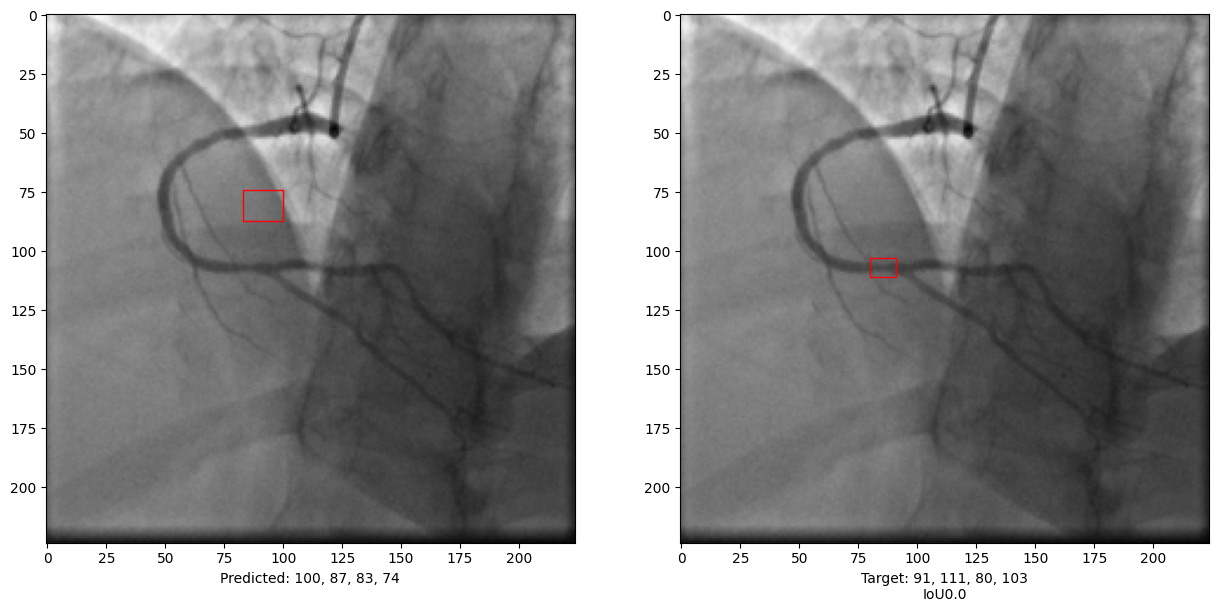

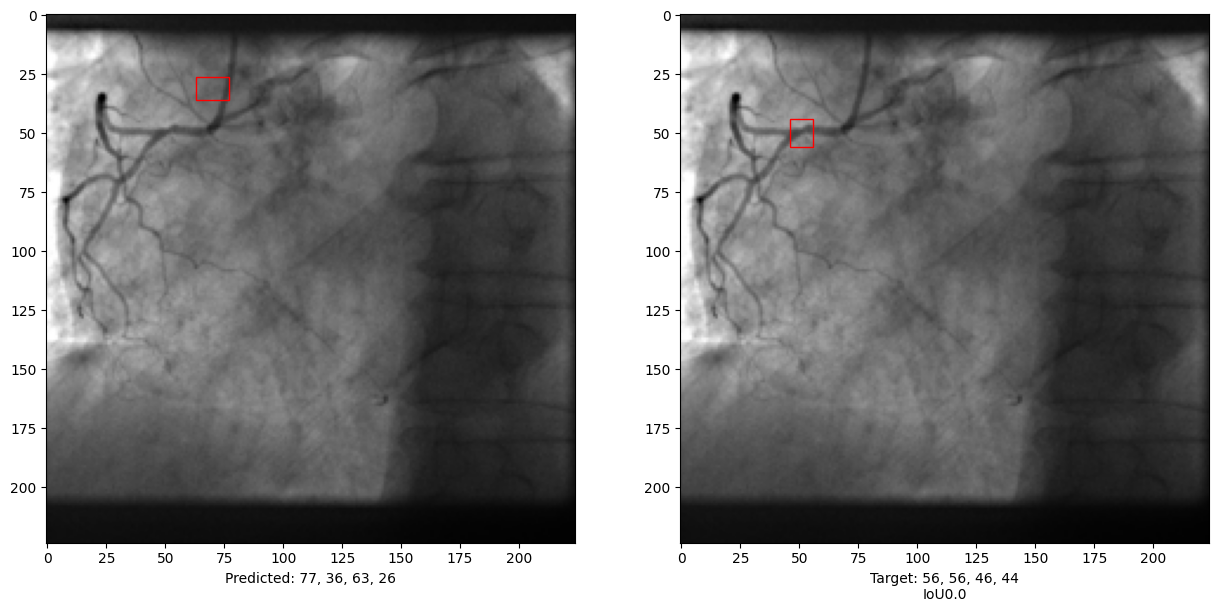

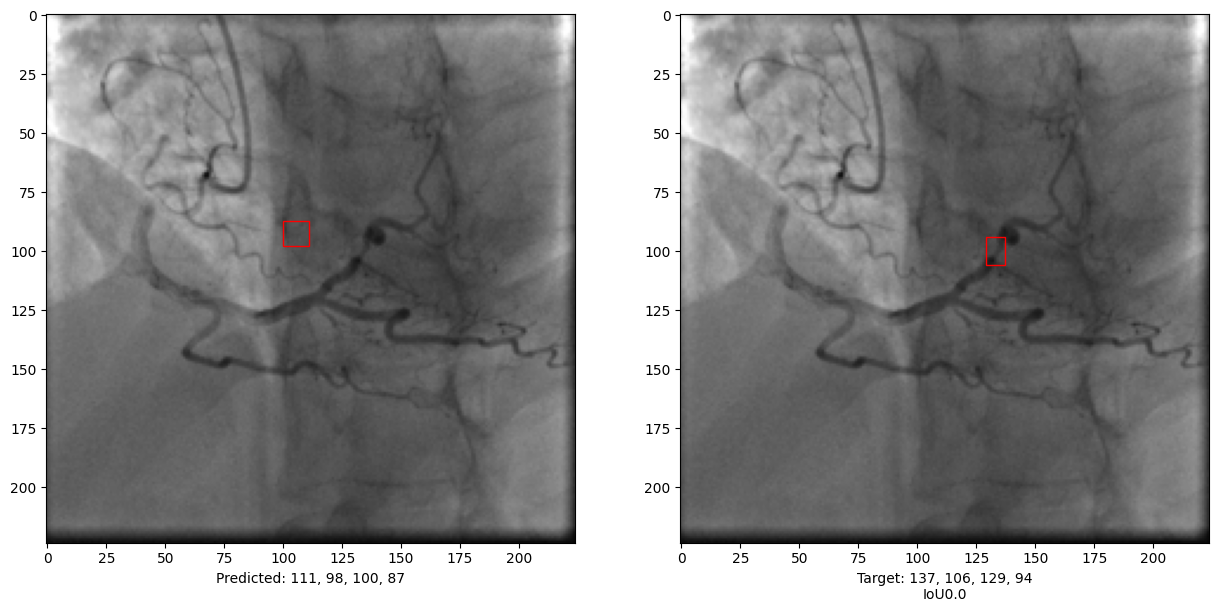

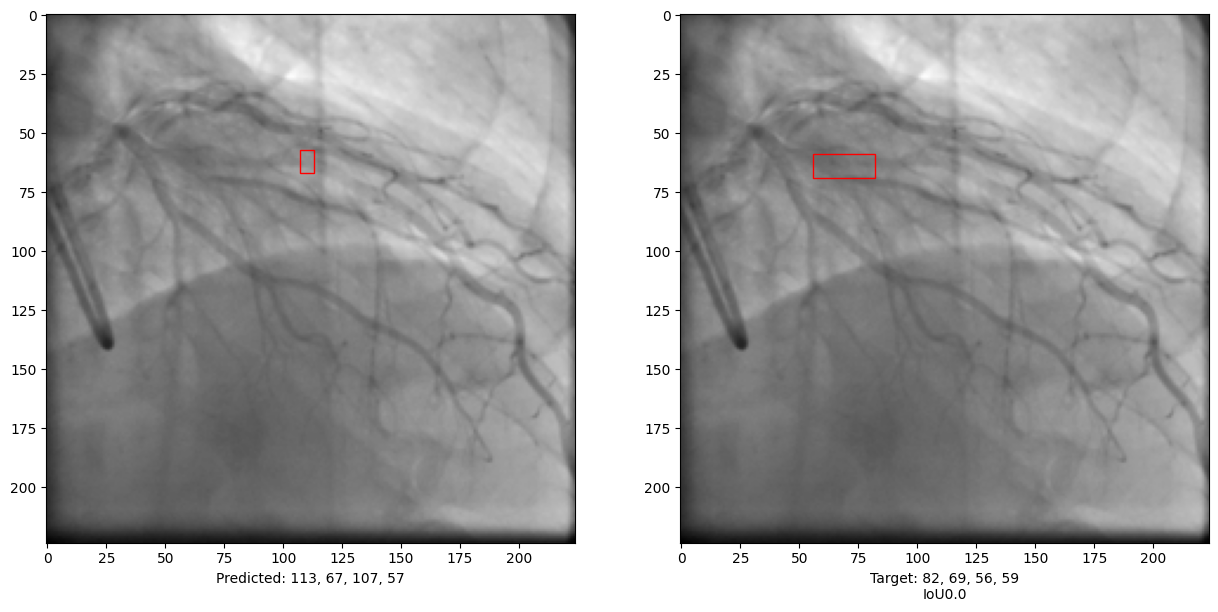

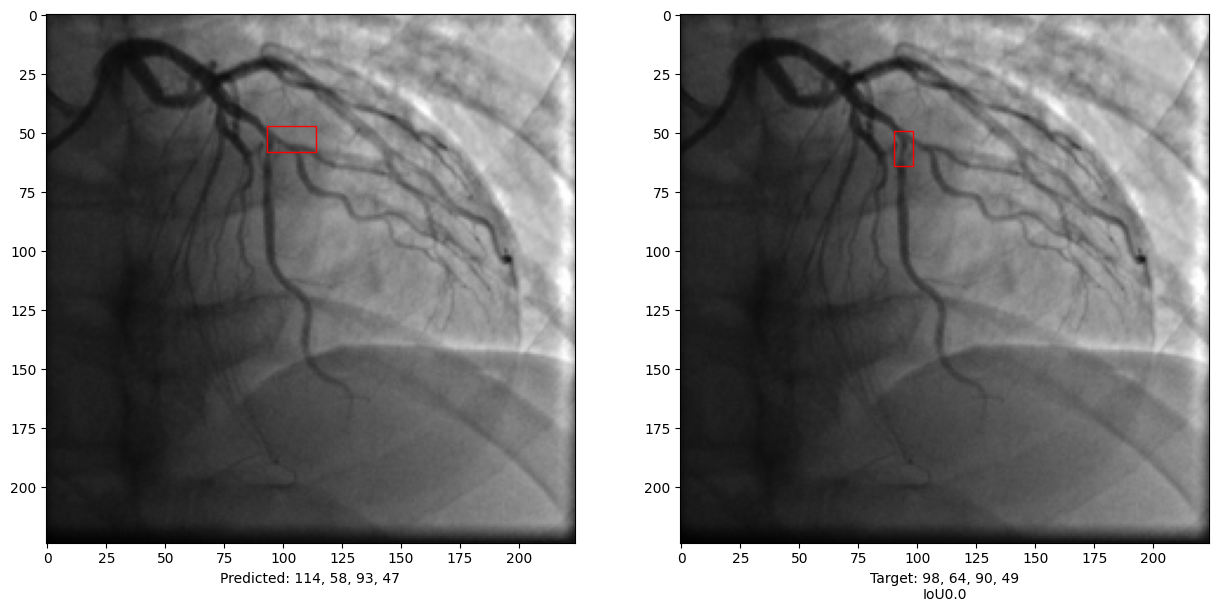

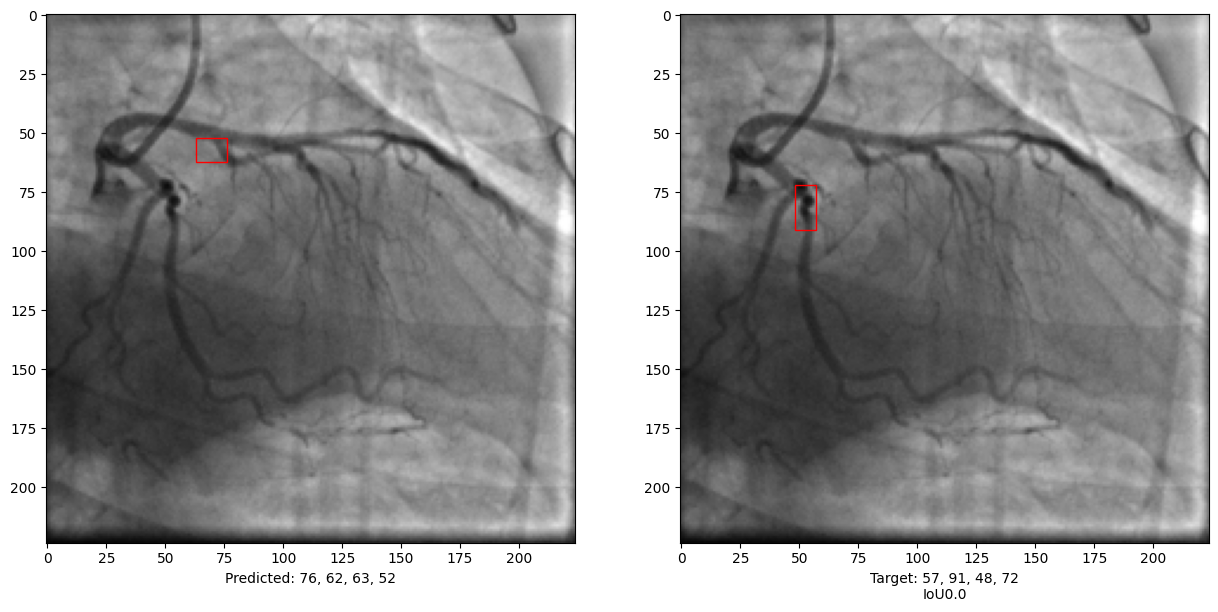

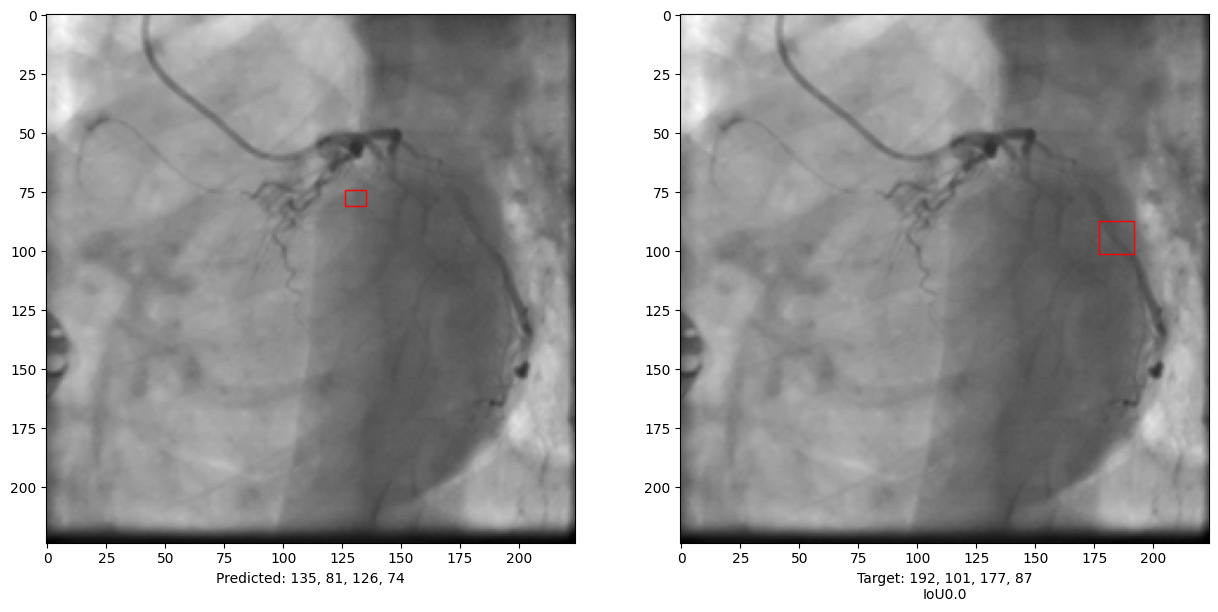

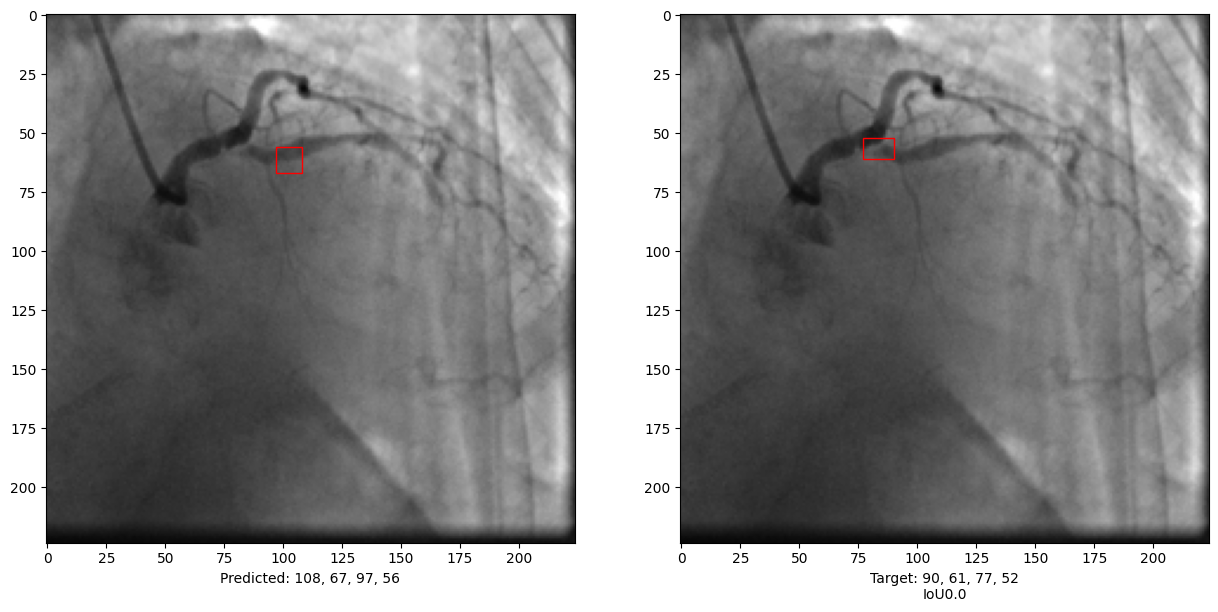

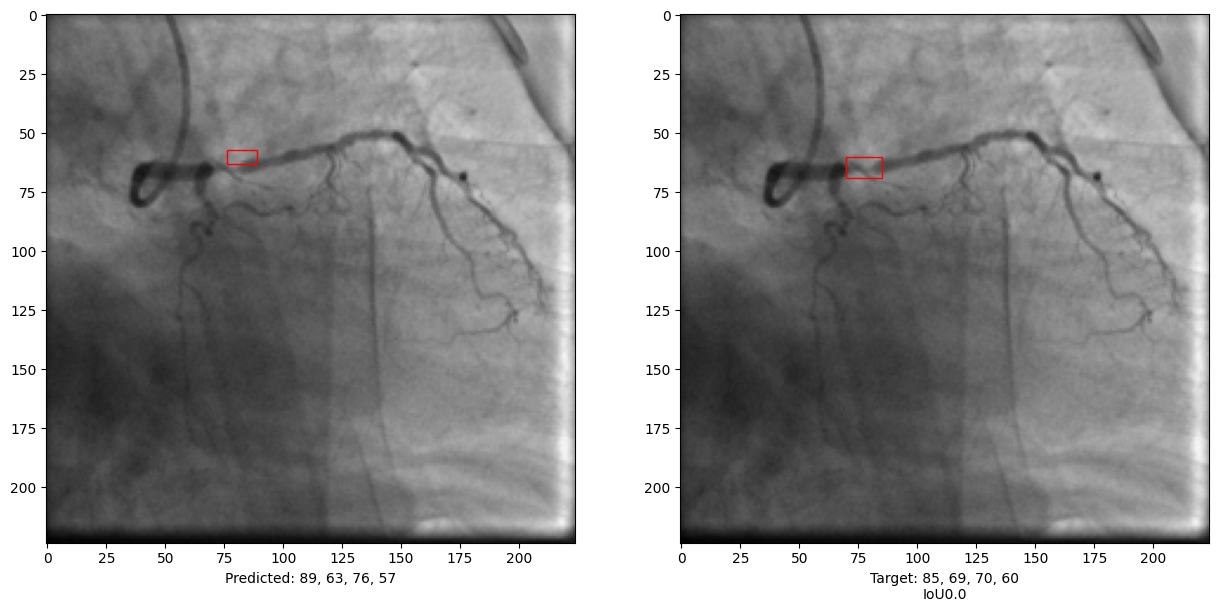

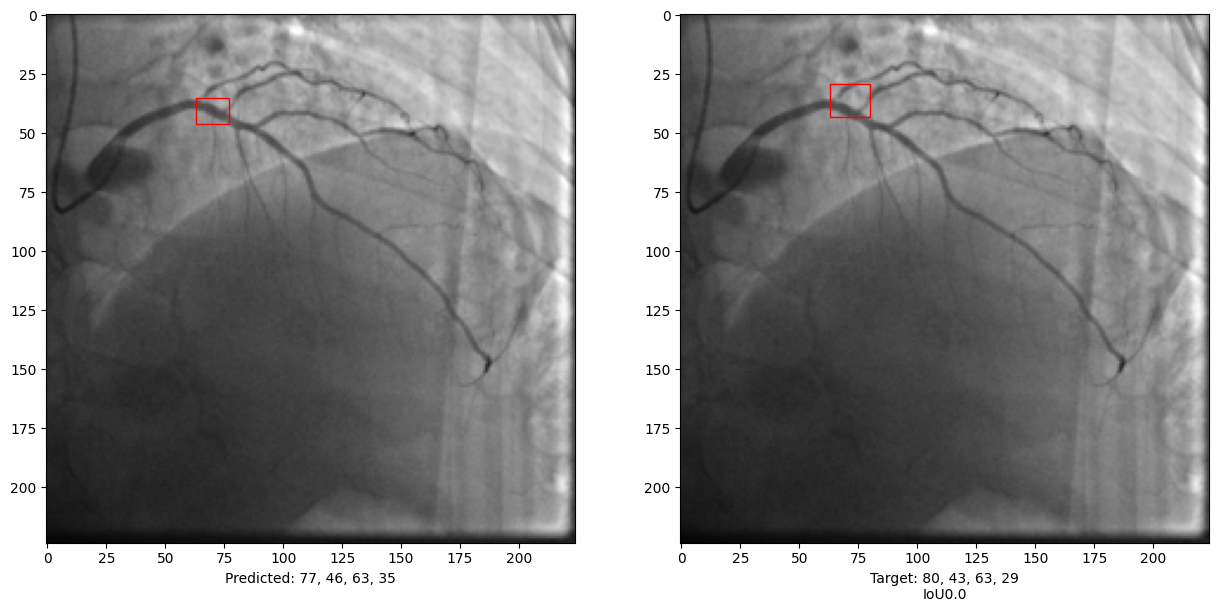

In [44]:
import matplotlib.patches as patches

def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )


    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)[0]
    print(preds)

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )
    print(y_test[i])

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)

    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
# print("mean_iou: " + str(mean_iou))

plt.show()